In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

import torch # import pytorch
import torch.nn as nn # pytorch's neural networks module
import torch.nn.functional as F # functional module.
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
#change path to the path in your drive

#Shrey's file paths

#Arvind's file paths

#Richard's file paths
X_test_np = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/X_test.npy") 
y_test_np = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/2023/23W/eec147/c147finalproject/person_test.npy")

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=12345)

In [5]:
print('Training/Valid data shape: {}'.format(X_train_valid.shape))
print('Test data shape: {}'.format(X_test_np.shape))
print('Training/Valid target shape: {}'.format(y_train_valid.shape))
print('Test target shape: {}'.format(y_test_np.shape))
print('Person train/valid shape: {}'.format(person_train_valid.shape))
print('Person test shape: {}'.format(person_test.shape))

'''
2115 training samples
443 testing samples
1000 time bins per sample
22 electrodes
11 possible labels
'''

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


'\n2115 training samples\n443 testing samples\n1000 time bins per sample\n22 electrodes\n11 possible labels\n'

In [6]:
def data_prep(X,y,sub_sample,average,noise, device, lastn = 500, firstn=0):
    
    y = (y - np.min(y)).astype('int')
    total_X = None
    total_y = None
    #print('Shape of X:',X.shape)
    #print('Shape of y:',y.shape)
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,firstn:lastn]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
     
    
    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    total_X = torch.FloatTensor(total_X).to(device)
    total_y = torch.LongTensor(total_y).to(device)

    return total_X,total_y
    
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [7]:
X_train_valid.shape, y_train_valid.shape

((2115, 22, 1000), (2115,))

In [8]:
'''
y_train_valid = (y_train_valid - np.min(y_train_valid)).astype('int')
y_test = (y_test - np.min(y_test)).astype('int')

X_train_valid,y_train_valid = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test,y_test = data_prep(X_test,y_test,2,2,True)
'''

"\ny_train_valid = (y_train_valid - np.min(y_train_valid)).astype('int')\ny_test = (y_test - np.min(y_test)).astype('int')\n\nX_train_valid,y_train_valid = data_prep(X_train_valid,y_train_valid,2,2,True)\nX_test,y_test = data_prep(X_test,y_test,2,2,True)\n"

CONV LSTM

In [9]:
print(torch.cuda.is_available())
device_id = 0 if torch.cuda.is_available() else 'cpu' # Equivalent to device_id = 'cuda:0'
device = torch.device(device_id) # use these semantics to specify a specific device. 


True


In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X) # 32-bit float
        else:
            self.X = X
        if isinstance(Y, np.ndarray):
            self.Y = torch.LongTensor(Y) # integer type
        else:
            self.Y = Y
        return
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [11]:
import tqdm

In [12]:
# from tutorial
class ConvLSTM(nn.Module):
    def __init__(self, input_shape=(22, 250), n_temporal_filters=40, n_spatial_filters=60, n_classes=4, lstm_hidden_ft=256, lstm_layers=3, batch_size=32, dropout=0.3):
        super().__init__() # call __init__ method of superclass
        
        self.input_shape = input_shape # last two dimensions, (excluding batch size). Should be length 2.
        self.lstm_layers = lstm_layers
        self.lstm_hidden_ft = lstm_hidden_ft
        self.n_temporal_filters = n_temporal_filters
        self.n_spatial_filters = n_spatial_filters
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.dropout = dropout
        if input_shape[1]%100 == 50:
          lstm_input = int(3.84*input_shape[1]-64)
        else:
          lstm_input = int(3.84*input_shape[1])
        if input_shape[1] == 450:
          lstm_input = 1792
        
        F = 8 #8
        D = 4 #4 
        self.conv = nn.Sequential(
          
            
            nn.Conv2d(1, F, (1, 32), padding='same'),
            nn.BatchNorm2d(F),

            nn.Conv2d(F, F*4, (1, 32), padding='same'),
            nn.BatchNorm2d(4*F),
            nn.ELU(),

            nn.Conv2d(F*4, F*D*4, (22, 1), groups=F*4),
            nn.BatchNorm2d(4*F*D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.7),

            nn.Conv2d(F*D*4, F*D*4, (1, 16), padding="same", dilation=(1, 4)),
            nn.BatchNorm2d(4*F*D),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.7)
            
        )

        self.lstm1 = nn.Sequential(
            nn.LSTM(lstm_input, 64, 2, batch_first=True, dropout = 0.6),
        )


        self.dense = nn.Sequential(            
            nn.Linear(64, n_classes),
            #nn.Softmax()
        )
        
        return
    
    # declaring a forward method also makes the instance a callable.
    # e.g.:
    # model = ShallowConvNet()
    # out = model(x)
    def forward(self, x):
        h = x

        h = h.view(-1, 1, self.input_shape[0], self.input_shape[1])
        h = self.conv(h)
        h = h.view(h.shape[0], -1)
        h, _ = self.lstm1(h)
        
        h = self.dense(h)
        return h




In [13]:
!pip install torchinfo
from torchinfo import summary
print(summary(ConvLSTM(), input_size=(22, 250)))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
ConvLSTM                                 [1, 4]                    --
├─Sequential: 1-1                        [1, 128, 1, 7]            --
│    └─Conv2d: 2-1                       [1, 8, 22, 250]           264
│    └─BatchNorm2d: 2-2                  [1, 8, 22, 250]           16
│    └─Conv2d: 2-3                       [1, 32, 22, 250]          8,224
│    └─BatchNorm2d: 2-4                  [1, 32, 22, 250]          64
│    └─ELU: 2-5                          [1, 32, 22, 250]          --
│    └─Conv2d: 2-6                       [1, 128, 1, 250]          2,944
│    └─BatchNorm2d: 2-7                  [1, 128, 1, 250]          256
│    └─ELU: 2-8                          [1, 128, 1, 250]          --
│    └─AvgPool2d: 2-9                    [1, 128, 1, 62]           --
│    └─Dropout: 2-10                     [1, 128, 1, 62]           --
│    └─Conv2d: 2-11                      [1, 128, 1, 62]           262,272
│ 

In [14]:
l2_reg = 1e-4

# This optimizer also has its own state dictionary

In [15]:
loss_hists = {}
val_loss_hists = {}
test_loss_hists = {}
acc_hists = {}
val_acc_hists = {}
test_acc_hists = {}

In [16]:
f = open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/stats.pkl', 'rb')
obj = pickle.load(f)
f.close()

In [17]:
for key in obj.keys():
  print(key)
  exec(key + " = obj['{}']".format(key))

loss_hists
val_loss_hists
test_loss_hists
acc_hists
val_acc_hists
test_acc_hists


In [18]:
for n in np.arange(100, 1100, 100):
  break

  X_train,y_train = data_prep(X_train_np,y_train_np,2,2,True, device, lastn=n)
  X_val,y_val = data_prep(X_val_np,y_val_np,2,2,True, device,  lastn=n)
  X_test,y_test = data_prep(X_test_np,y_test_np,2,2,True, device,  lastn=n)
  batch_size = 32

  train_dataset = MyDataset(X_train, y_train)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

  val_dataset = MyDataset(X_val, y_val)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

  test_dataset = MyDataset(X_test, y_test)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

  loss_hist = []
  val_loss_hist = []
  acc_hist = []
  val_acc_hist = []

  test_loss_hist = []
  test_acc_hist = []

  num_epochs = 100
  CUDA_LAUNCH_BLOCKING=1

  # progress bar
  pbar = tqdm.tqdm(
      range(num_epochs), position=0, leave=True,
      bar_format='{l_bar}{bar:30}{r_bar}',
  )
  model = ConvLSTM(input_shape=(22, int(n/2))).to(device)
  optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0005)
  celoss = nn.CrossEntropyLoss()
  for epoch in pbar:
      model.train() # set model to training mode.
      for batch in train_dataloader:
          optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
          x, y = batch
          # x = x.to(device) # necessary if X is not on the same device as model
          # y = y.to(device)

          out = model(x) # shape (batch_size, n_classes)
          loss = celoss(out, y) # calculate the cross entropy loss

          loss.backward() # backpropagate
          optimizer.step() # perform optimization step
          #scheduler.step()

          # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
          # Otherwise you will run out of memory.
          # You MUST use .item() to convert to a scalar or call .detach().
          loss_hist.append(loss.item())
      
      model.eval() # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
      # calculate accuracy for training and validation sets
      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in train_dataloader:
              x, y = batch
              
              out = model(x)
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      acc_hist.append(nc/ns)

      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in val_dataloader:
              x, y = batch
              out = model(x)
              loss = celoss(out, y)
              val_loss_hist.append(loss.item())
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      val_acc_hist.append(nc/ns)

      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in test_dataloader:
              x, y = batch
              out = model(x)
              loss = celoss(out, y)
              test_loss_hist.append(loss.item())
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      test_acc_hist.append(nc/ns)


      # update progress bar postfix
      pbar.set_postfix({'last-n': n, 'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1], 'test_acc': test_acc_hist[-1]})

      if test_acc_hist[-1] > 1.725:
        break
  loss_hists[n] = loss_hist
  val_loss_hists[n] = val_loss_hist
  test_loss_hists[n] = test_loss_hist
  acc_hists[n] = acc_hist
  val_acc_hists[n] = val_acc_hist
  test_acc_hists[n]= test_acc_hist

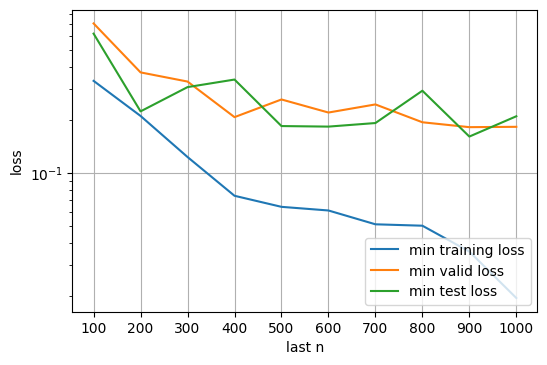

In [19]:
plt.figure(dpi=100)

plt.plot([np.min(i) for i in loss_hists.values()], label='min training loss')
plt.plot([np.min(i) for i in val_loss_hists.values()], label='min valid loss')
plt.plot([np.min(i) for i in test_loss_hists.values()], label='min test loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xticks(range(len(loss_hists.keys())), loss_hists.keys())
plt.legend(loc='lower right')
plt.xlabel('last n')
#min_n = np.argmin([np.min(i) for i in test_loss_hists.values()])
#plt.plot(min_n, [np.min(i) for i in test_loss_hists.values()][min_n], marker="*", ms=20, color="gold")
plt.grid()

In [20]:
'''
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/stats.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump({'loss_hists':loss_hists, 'val_loss_hists':val_loss_hists, 'test_loss_hists':test_loss_hists, 'acc_hists':acc_hists, 'val_acc_hists':val_acc_hists, 'test_acc_hists':test_acc_hists}, f)
    '''

"\nimport pickle\n\n# obj0, obj1, obj2 are created here...\n\n# Saving the objects:\nwith open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/stats.pkl', 'wb') as f:  # Python 3: open(..., 'wb')\n    pickle.dump({'loss_hists':loss_hists, 'val_loss_hists':val_loss_hists, 'test_loss_hists':test_loss_hists, 'acc_hists':acc_hists, 'val_acc_hists':val_acc_hists, 'test_acc_hists':test_acc_hists}, f)\n    "

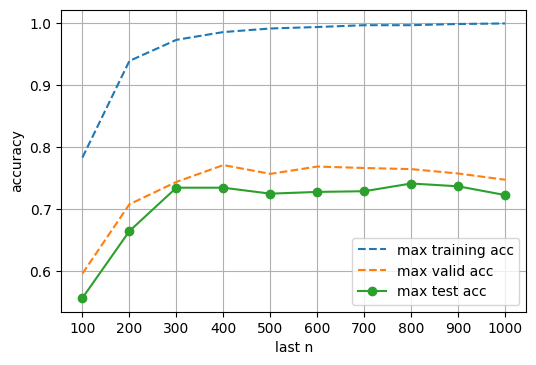

In [21]:
plt.figure(dpi=100)

plt.plot([np.max(i) for i in acc_hists.values()], label='max training acc',linestyle='--',)
plt.plot([np.max(i) for i in val_acc_hists.values()], label='max valid acc',linestyle='--',)
plt.plot([np.max(i) for i in test_acc_hists.values()], label='max test acc', marker='o')

#max_n = np.argmax([np.max(i) for i in test_acc_hists.values()])

#plt.plot(max_n, [np.max(i) for i in test_acc_hists.values()][max_n], marker="*", ms=20, color="gold")

plt.ylabel('accuracy')
plt.xticks(range(len(loss_hists.keys())), loss_hists.keys())
plt.legend(loc='lower right')
plt.xlabel('last n')
plt.grid()


In [22]:
[np.max(i) for i in test_acc_hists.values()]

[0.5564334085778782,
 0.6642212189616253,
 0.7341986455981941,
 0.7341986455981941,
 0.7246049661399548,
 0.7274266365688488,
 0.7285553047404063,
 0.7409706546275395,
 0.7364559819413092,
 0.7223476297968398]

In [23]:
loss_hists = {}
val_loss_hists = {}
test_loss_hists = {}
acc_hists = {}
val_acc_hists = {}
test_acc_hists = {}

In [24]:
f = open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/800window_stats.pkl', 'rb')
obj = pickle.load(f)
f.close()

In [25]:
for key in obj.keys():
  print(key)
  exec(key + " = obj['{}']".format(key))

loss_hists
val_loss_hists
test_loss_hists
acc_hists
val_acc_hists
test_acc_hists


In [26]:
for n in np.arange(0, 300, 100):
  break
  print(n)
  X_train,y_train = data_prep(X_train_np,y_train_np,2,2,True, device, firstn = n, lastn=n+800)
  X_val,y_val = data_prep(X_val_np,y_val_np,2,2,True, device,  firstn = n, lastn=n+800)
  X_test,y_test = data_prep(X_test_np,y_test_np,2,2,True, device, firstn = n, lastn=n+800)
  batch_size = 32

  train_dataset = MyDataset(X_train, y_train)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

  val_dataset = MyDataset(X_val, y_val)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

  test_dataset = MyDataset(X_test, y_test)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

  loss_hist = []
  val_loss_hist = []
  acc_hist = []
  val_acc_hist = []

  test_loss_hist = []
  test_acc_hist = []

  num_epochs = 100
  CUDA_LAUNCH_BLOCKING=1

  # progress bar
  pbar = tqdm.tqdm(
      range(num_epochs), position=0, leave=True,
      bar_format='{l_bar}{bar:30}{r_bar}',
  )
  model = ConvLSTM(input_shape=(22, int(800/2))).to(device)
  optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0005)
  celoss = nn.CrossEntropyLoss()
  for epoch in pbar:
      model.train() # set model to training mode.
      for batch in train_dataloader:
          optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
          x, y = batch
          # x = x.to(device) # necessary if X is not on the same device as model
          # y = y.to(device)

          out = model(x) # shape (batch_size, n_classes)
          loss = celoss(out, y) # calculate the cross entropy loss

          loss.backward() # backpropagate
          optimizer.step() # perform optimization step
          #scheduler.step()

          # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
          # Otherwise you will run out of memory.
          # You MUST use .item() to convert to a scalar or call .detach().
          loss_hist.append(loss.item())
      
      model.eval() # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
      # calculate accuracy for training and validation sets
      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in train_dataloader:
              x, y = batch
              
              out = model(x)
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      acc_hist.append(nc/ns)

      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in val_dataloader:
              x, y = batch
              out = model(x)
              loss = celoss(out, y)
              val_loss_hist.append(loss.item())
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      val_acc_hist.append(nc/ns)

      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in test_dataloader:
              x, y = batch
              out = model(x)
              loss = celoss(out, y)
              test_loss_hist.append(loss.item())
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      test_acc_hist.append(nc/ns)


      # update progress bar postfix
      pbar.set_postfix({'last-n': n, 'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1], 'test_acc': test_acc_hist[-1]})

      if test_acc_hist[-1] > 1.725:
        break
  loss_hists[n] = loss_hist
  val_loss_hists[n] = val_loss_hist
  test_loss_hists[n] = test_loss_hist
  acc_hists[n] = acc_hist
  val_acc_hists[n] = val_acc_hist
  test_acc_hists[n]= test_acc_hist

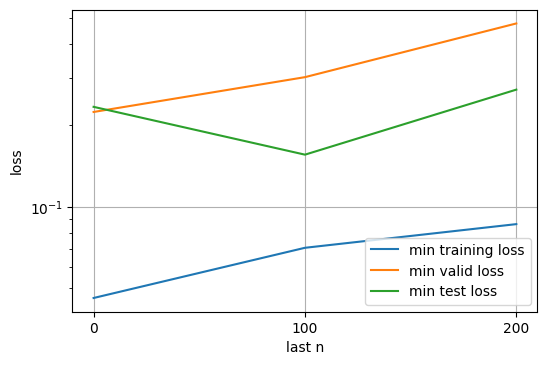

In [27]:
plt.figure(dpi=100)

plt.plot([np.min(i) for i in loss_hists.values()], label='min training loss')
plt.plot([np.min(i) for i in val_loss_hists.values()], label='min valid loss')
plt.plot([np.min(i) for i in test_loss_hists.values()], label='min test loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xticks(range(len(loss_hists.keys())), loss_hists.keys())
plt.legend(loc='lower right')
plt.xlabel('starting index')
#min_n = np.argmin([np.min(i) for i in test_loss_hists.values()])
#plt.plot(min_n, [np.min(i) for i in test_loss_hists.values()][min_n], marker="*", ms=20, color="gold")
plt.grid()

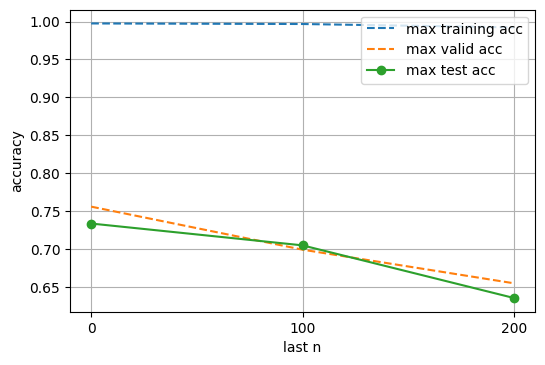

In [28]:
plt.figure(dpi=100)

plt.plot([np.max(i) for i in acc_hists.values()], label='max training acc',linestyle='--',)
plt.plot([np.max(i) for i in val_acc_hists.values()], label='max valid acc',linestyle='--',)
plt.plot([np.max(i) for i in test_acc_hists.values()], label='max test acc', marker='o')

#max_n = np.argmax([np.max(i) for i in test_acc_hists.values()])

#plt.plot(max_n, [np.max(i) for i in test_acc_hists.values()][max_n], marker="*", ms=20, color="gold")

plt.ylabel('accuracy')
plt.xticks(range(len(loss_hists.keys())), loss_hists.keys())
plt.legend(loc='upper right')
plt.xlabel('starting index')
plt.grid()


In [29]:
'''
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/800window_stats.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump({'loss_hists':loss_hists, 'val_loss_hists':val_loss_hists, 'test_loss_hists':test_loss_hists, 'acc_hists':acc_hists, 'val_acc_hists':val_acc_hists, 'test_acc_hists':test_acc_hists}, f)
    '''

"\nimport pickle\n\n# obj0, obj1, obj2 are created here...\n\n# Saving the objects:\nwith open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/800window_stats.pkl', 'wb') as f:  # Python 3: open(..., 'wb')\n    pickle.dump({'loss_hists':loss_hists, 'val_loss_hists':val_loss_hists, 'test_loss_hists':test_loss_hists, 'acc_hists':acc_hists, 'val_acc_hists':val_acc_hists, 'test_acc_hists':test_acc_hists}, f)\n    "

In [29]:
f = open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/300window_stats.pkl', 'rb')
obj = pickle.load(f)
f.close()

In [ ]:
for key in obj.keys():
  print(key)
  exec(key + " = obj['{}']".format(key))

In [30]:
for n in np.arange(0, 800, 100):
  
  print(n)
  X_train,y_train = data_prep(X_train_np,y_train_np,2,2,True, device, firstn = n, lastn=n+300)
  X_val,y_val = data_prep(X_val_np,y_val_np,2,2,True, device,  firstn = n, lastn=n+300)
  X_test,y_test = data_prep(X_test_np,y_test_np,2,2,True, device, firstn = n, lastn=n+300)
  batch_size = 32

  train_dataset = MyDataset(X_train, y_train)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

  val_dataset = MyDataset(X_val, y_val)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

  test_dataset = MyDataset(X_test, y_test)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

  loss_hist = []
  val_loss_hist = []
  acc_hist = []
  val_acc_hist = []

  test_loss_hist = []
  test_acc_hist = []

  num_epochs = 100
  CUDA_LAUNCH_BLOCKING=1

  # progress bar
  pbar = tqdm.tqdm(
      range(num_epochs), position=0, leave=True,
      bar_format='{l_bar}{bar:30}{r_bar}',
  )
  model = ConvLSTM(input_shape=(22, int(300/2))).to(device)
  optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0005)
  celoss = nn.CrossEntropyLoss()
  for epoch in pbar:
      model.train() # set model to training mode.
      for batch in train_dataloader:
          optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
          x, y = batch
          # x = x.to(device) # necessary if X is not on the same device as model
          # y = y.to(device)

          out = model(x) # shape (batch_size, n_classes)
          loss = celoss(out, y) # calculate the cross entropy loss

          loss.backward() # backpropagate
          optimizer.step() # perform optimization step
          #scheduler.step()

          # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
          # Otherwise you will run out of memory.
          # You MUST use .item() to convert to a scalar or call .detach().
          loss_hist.append(loss.item())
      
      model.eval() # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
      # calculate accuracy for training and validation sets
      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in train_dataloader:
              x, y = batch
              
              out = model(x)
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      acc_hist.append(nc/ns)

      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in val_dataloader:
              x, y = batch
              out = model(x)
              loss = celoss(out, y)
              val_loss_hist.append(loss.item())
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      val_acc_hist.append(nc/ns)

      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in test_dataloader:
              x, y = batch
              out = model(x)
              loss = celoss(out, y)
              test_loss_hist.append(loss.item())
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      test_acc_hist.append(nc/ns)


      # update progress bar postfix
      pbar.set_postfix({'last-n': n, 'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1], 'test_acc': test_acc_hist[-1]})

      if test_acc_hist[-1] > 1.725:
        break
  loss_hists[n] = loss_hist
  val_loss_hists[n] = val_loss_hist
  test_loss_hists[n] = test_loss_hist
  acc_hists[n] = acc_hist
  val_acc_hists[n] = val_acc_hist
  test_acc_hists[n]= test_acc_hist

0


100%|██████████████████████████████| 100/100 [08:13<00:00,  4.94s/it, last-n=0, acc=0.954, val_acc=0.706, test_acc=0.706]


100


100%|██████████████████████████████| 100/100 [08:00<00:00,  4.80s/it, last-n=100, acc=0.944, val_acc=0.666, test_acc=0.638]


200


100%|██████████████████████████████| 100/100 [08:02<00:00,  4.83s/it, last-n=200, acc=0.935, val_acc=0.638, test_acc=0.611]


300


100%|██████████████████████████████| 100/100 [07:58<00:00,  4.79s/it, last-n=300, acc=0.918, val_acc=0.531, test_acc=0.521]


400


100%|██████████████████████████████| 100/100 [07:58<00:00,  4.78s/it, last-n=400, acc=0.854, val_acc=0.432, test_acc=0.4]


500


100%|██████████████████████████████| 100/100 [08:05<00:00,  4.85s/it, last-n=500, acc=0.844, val_acc=0.35, test_acc=0.376]


600


100%|██████████████████████████████| 100/100 [07:57<00:00,  4.77s/it, last-n=600, acc=0.84, val_acc=0.328, test_acc=0.357]


700


100%|██████████████████████████████| 100/100 [07:57<00:00,  4.77s/it, last-n=700, acc=0.795, val_acc=0.304, test_acc=0.316]


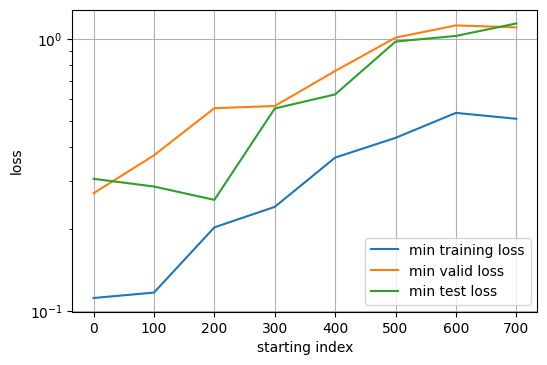

In [34]:
plt.figure(dpi=100)

plt.plot([np.min(i) for i in loss_hists.values()], label='min training loss')
plt.plot([np.min(i) for i in val_loss_hists.values()], label='min valid loss')
plt.plot([np.min(i) for i in test_loss_hists.values()], label='min test loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xticks(range(len(loss_hists.keys())), loss_hists.keys())
plt.legend(loc='lower right')
plt.xlabel('starting index')
#min_n = np.argmin([np.min(i) for i in test_loss_hists.values()])
#plt.plot(min_n, [np.min(i) for i in test_loss_hists.values()][min_n], marker="*", ms=20, color="gold")
plt.grid()

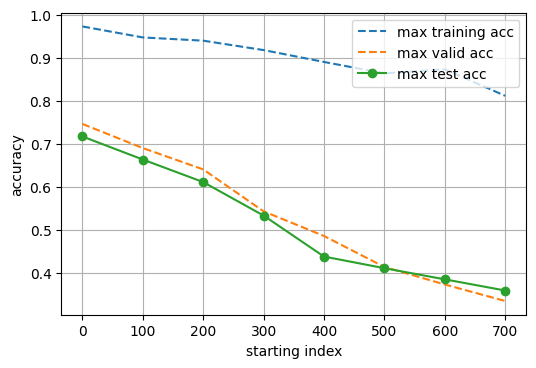

In [35]:
plt.figure(dpi=100)

plt.plot([np.max(i) for i in acc_hists.values()], label='max training acc',linestyle='--',)
plt.plot([np.max(i) for i in val_acc_hists.values()], label='max valid acc',linestyle='--',)
plt.plot([np.max(i) for i in test_acc_hists.values()], label='max test acc', marker='o')

#max_n = np.argmax([np.max(i) for i in test_acc_hists.values()])

#plt.plot(max_n, [np.max(i) for i in test_acc_hists.values()][max_n], marker="*", ms=20, color="gold")

plt.ylabel('accuracy')
plt.xticks(range(len(loss_hists.keys())), loss_hists.keys())
plt.legend(loc='upper right')
plt.xlabel('starting index')
plt.grid()


In [33]:
'''
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/300window_stats.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump({'loss_hists':loss_hists, 'val_loss_hists':val_loss_hists, 'test_loss_hists':test_loss_hists, 'acc_hists':acc_hists, 'val_acc_hists':val_acc_hists, 'test_acc_hists':test_acc_hists}, f)
'''
    

In [ ]:
f = open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/100window_stats.pkl', 'rb')
obj = pickle.load(f)
f.close()

In [ ]:
for key in obj.keys():
  print(key)
  exec(key + " = obj['{}']".format(key))

In [36]:
for n in np.arange(0, 1000, 100):
  
  print(n)
  X_train,y_train = data_prep(X_train_np,y_train_np,2,2,True, device, firstn = n, lastn=n+100)
  X_val,y_val = data_prep(X_val_np,y_val_np,2,2,True, device,  firstn = n, lastn=n+100)
  X_test,y_test = data_prep(X_test_np,y_test_np,2,2,True, device, firstn = n, lastn=n+100)
  batch_size = 32

  train_dataset = MyDataset(X_train, y_train)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

  val_dataset = MyDataset(X_val, y_val)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

  test_dataset = MyDataset(X_test, y_test)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

  loss_hist = []
  val_loss_hist = []
  acc_hist = []
  val_acc_hist = []

  test_loss_hist = []
  test_acc_hist = []

  num_epochs = 100
  CUDA_LAUNCH_BLOCKING=1

  # progress bar
  pbar = tqdm.tqdm(
      range(num_epochs), position=0, leave=True,
      bar_format='{l_bar}{bar:30}{r_bar}',
  )
  model = ConvLSTM(input_shape=(22, int(100/2))).to(device)
  optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0005)
  celoss = nn.CrossEntropyLoss()
  for epoch in pbar:
      model.train() # set model to training mode.
      for batch in train_dataloader:
          optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
          x, y = batch
          # x = x.to(device) # necessary if X is not on the same device as model
          # y = y.to(device)

          out = model(x) # shape (batch_size, n_classes)
          loss = celoss(out, y) # calculate the cross entropy loss

          loss.backward() # backpropagate
          optimizer.step() # perform optimization step
          #scheduler.step()

          # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
          # Otherwise you will run out of memory.
          # You MUST use .item() to convert to a scalar or call .detach().
          loss_hist.append(loss.item())
      
      model.eval() # set model to evaluation mode. Relevant for dropout, batchnorm, layernorm, etc.
      # calculate accuracy for training and validation sets
      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in train_dataloader:
              x, y = batch
              
              out = model(x)
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      acc_hist.append(nc/ns)

      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in val_dataloader:
              x, y = batch
              out = model(x)
              loss = celoss(out, y)
              val_loss_hist.append(loss.item())
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      val_acc_hist.append(nc/ns)

      ns = 0 # number of samples
      nc = 0 # number of correct outputs
      with torch.no_grad():
          for batch in test_dataloader:
              x, y = batch
              out = model(x)
              loss = celoss(out, y)
              test_loss_hist.append(loss.item())
              ns += len(y)
              nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
      test_acc_hist.append(nc/ns)


      # update progress bar postfix
      pbar.set_postfix({'last-n': n, 'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1], 'test_acc': test_acc_hist[-1]})

      if test_acc_hist[-1] > 1.725:
        break
  loss_hists[n] = loss_hist
  val_loss_hists[n] = val_loss_hist
  test_loss_hists[n] = test_loss_hist
  acc_hists[n] = acc_hist
  val_acc_hists[n] = val_acc_hist
  test_acc_hists[n]= test_acc_hist

0


100%|██████████████████████████████| 100/100 [06:08<00:00,  3.69s/it, last-n=0, acc=0.779, val_acc=0.551, test_acc=0.54]


100


100%|██████████████████████████████| 100/100 [06:01<00:00,  3.62s/it, last-n=100, acc=0.755, val_acc=0.515, test_acc=0.488]


200


100%|██████████████████████████████| 100/100 [06:06<00:00,  3.67s/it, last-n=200, acc=0.703, val_acc=0.483, test_acc=0.478]


300


100%|██████████████████████████████| 100/100 [06:02<00:00,  3.63s/it, last-n=300, acc=0.727, val_acc=0.467, test_acc=0.426]


400


100%|██████████████████████████████| 100/100 [06:02<00:00,  3.63s/it, last-n=400, acc=0.687, val_acc=0.405, test_acc=0.362]


500


100%|██████████████████████████████| 100/100 [06:03<00:00,  3.64s/it, last-n=500, acc=0.425, val_acc=0.302, test_acc=0.31]


600


100%|██████████████████████████████| 100/100 [06:01<00:00,  3.62s/it, last-n=600, acc=0.44, val_acc=0.259, test_acc=0.29]


700


100%|██████████████████████████████| 100/100 [06:02<00:00,  3.63s/it, last-n=700, acc=0.395, val_acc=0.304, test_acc=0.3]


800


100%|██████████████████████████████| 100/100 [06:02<00:00,  3.62s/it, last-n=800, acc=0.4, val_acc=0.285, test_acc=0.284]


900


100%|██████████████████████████████| 100/100 [06:02<00:00,  3.62s/it, last-n=900, acc=0.353, val_acc=0.275, test_acc=0.26]


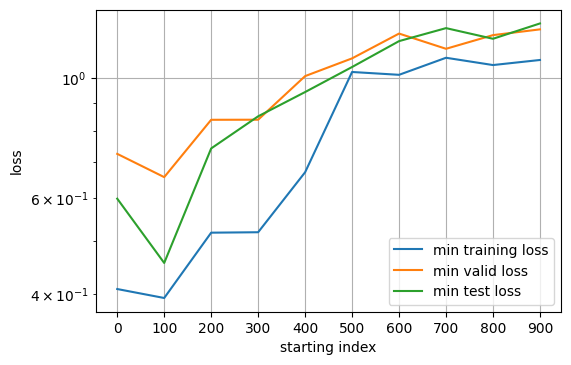

In [37]:
plt.figure(dpi=100)

plt.plot([np.min(i) for i in loss_hists.values()], label='min training loss')
plt.plot([np.min(i) for i in val_loss_hists.values()], label='min valid loss')
plt.plot([np.min(i) for i in test_loss_hists.values()], label='min test loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xticks(range(len(loss_hists.keys())), loss_hists.keys())
plt.legend(loc='lower right')
plt.xlabel('starting index')
#min_n = np.argmin([np.min(i) for i in test_loss_hists.values()])
#plt.plot(min_n, [np.min(i) for i in test_loss_hists.values()][min_n], marker="*", ms=20, color="gold")
plt.grid()

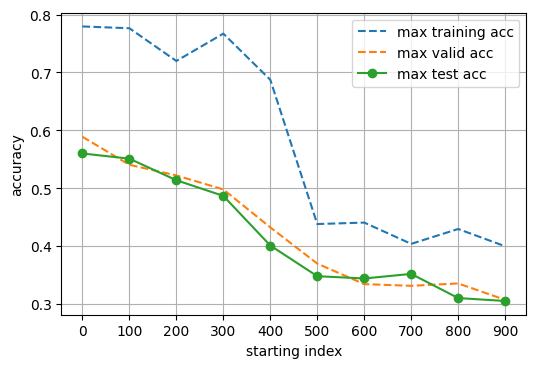

In [38]:
plt.figure(dpi=100)

plt.plot([np.max(i) for i in acc_hists.values()], label='max training acc',linestyle='--',)
plt.plot([np.max(i) for i in val_acc_hists.values()], label='max valid acc',linestyle='--',)
plt.plot([np.max(i) for i in test_acc_hists.values()], label='max test acc', marker='o')

#max_n = np.argmax([np.max(i) for i in test_acc_hists.values()])

#plt.plot(max_n, [np.max(i) for i in test_acc_hists.values()][max_n], marker="*", ms=20, color="gold")

plt.ylabel('accuracy')
plt.xticks(range(len(loss_hists.keys())), loss_hists.keys())
plt.legend(loc='upper right')
plt.xlabel('starting index')
plt.grid()


In [ ]:
'''
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('/content/drive/MyDrive/2023/23W/eec147/c147finalproject/100window_stats.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump({'loss_hists':loss_hists, 'val_loss_hists':val_loss_hists, 'test_loss_hists':test_loss_hists, 'acc_hists':acc_hists, 'val_acc_hists':val_acc_hists, 'test_acc_hists':test_acc_hists}, f)
'''
    